# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [35]:
RANDOM_STATE = np.random.RandomState(42)
TEST_SIZE = 0.25

## Загрузка и подготовка данных

### Загрузка и предобработка данных

In [36]:
geo_0 = pd.read_csv("datasets/geo_data_0.csv")
geo_1 = pd.read_csv("datasets/geo_data_1.csv")
geo_2 = pd.read_csv("datasets/geo_data_2.csv")

In [37]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [38]:
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [39]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [40]:
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [41]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [42]:
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [43]:
geo_0.duplicated().sum()

np.int64(0)

In [44]:
geo_1.duplicated().sum()

np.int64(0)

In [45]:
geo_2.duplicated().sum()

np.int64(0)

#### Вывод

Пропуски и дубликаты не обнаружены.

### Иследовательский анализ

In [46]:
def my_hist(df):
    for col in ["f0", "f1", "f2", "product"]:
        df[col].plot(
            kind='hist', 
            bins=15, 
            title=col, 
            figsize=(8, 5),
            color=sns.color_palette("viridis")[2:5]
        )
        plt.show()
    print(df.describe())

#### Первый регион

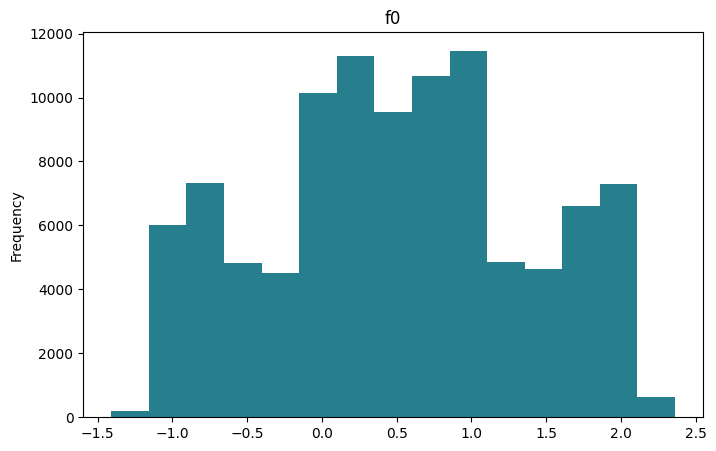

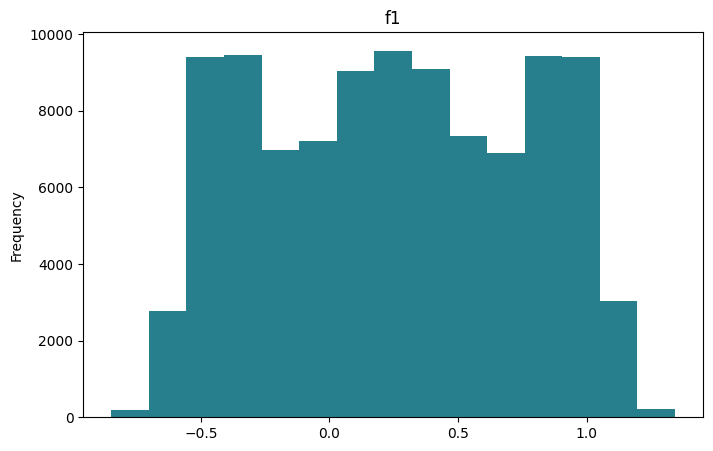

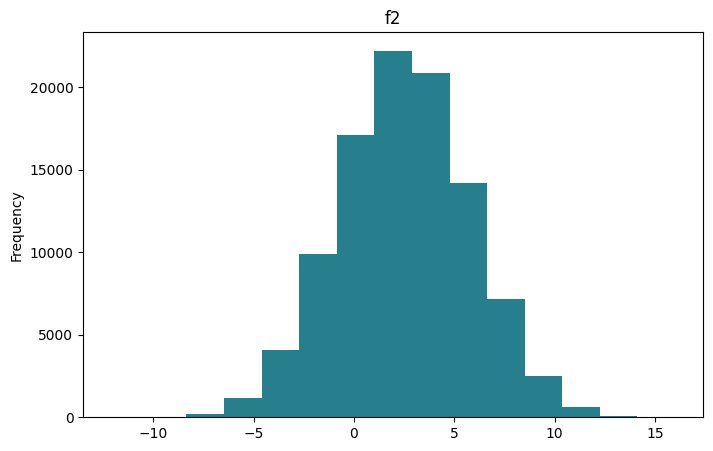

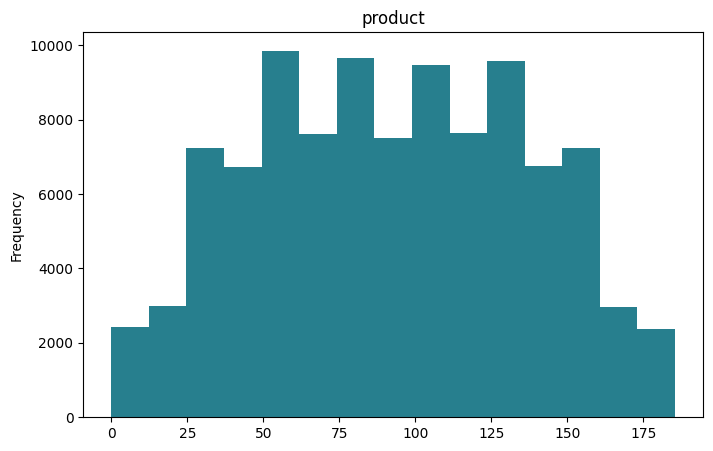

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347


In [47]:
my_hist(geo_0)

Признак "f0" распределен приблизительно от -1,4 до 2,4, симетрично вокруг среднего в 0,5 и имеет 4 пика, в районе -1, 0, 1, 2.\
Признак "f1" распределен приблизительно от -0,9 до 1,4, симетрично вокруг среднего в 0,25 и имеет 3 пика, в районе -0,5, 0,25, 1.\
Признак "f2" распределен нормально от -12 до 16, со среднем в 2,50 и стандартным отклонением в 3,24.\
Признак "product" распределен симетрично от 0 до 185, вокруг среднего в 92, имеет несколько пиков с шагом в 50 единиц и стандартное отклонение 44.

#### Второй регион

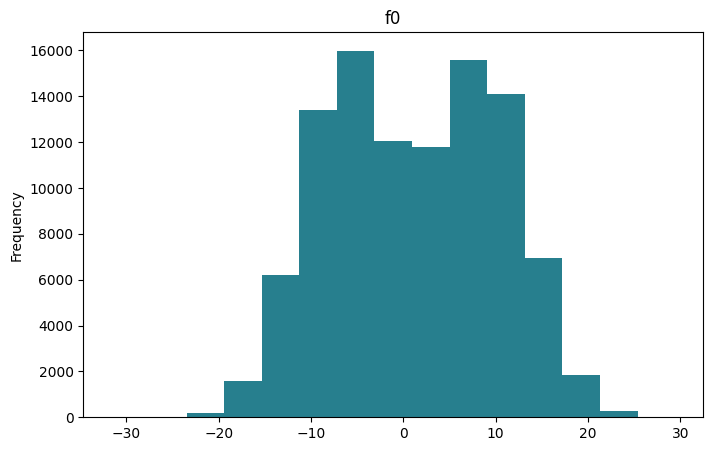

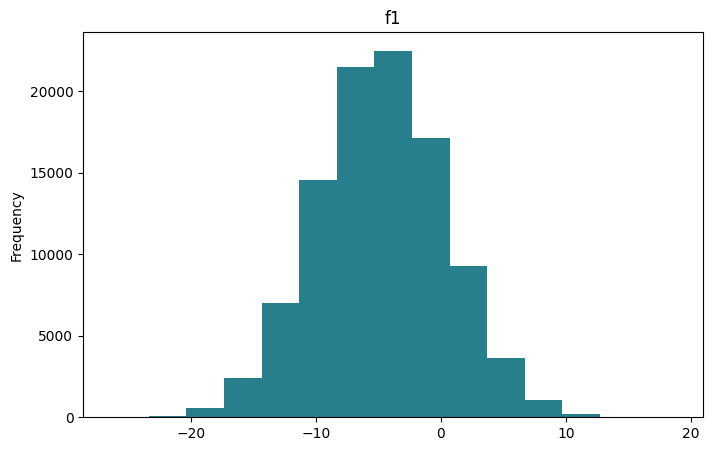

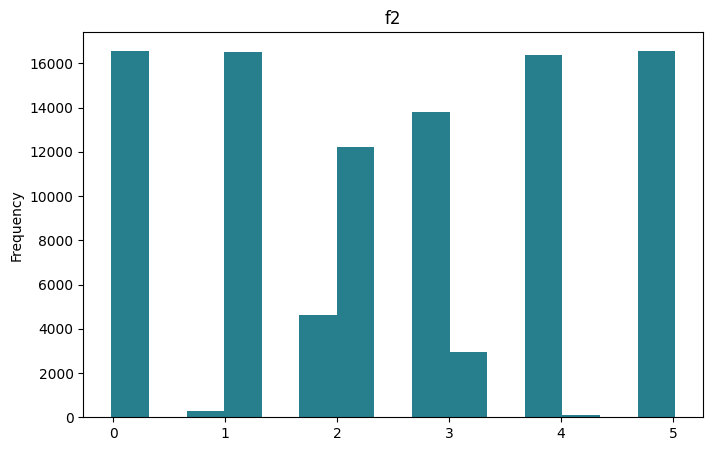

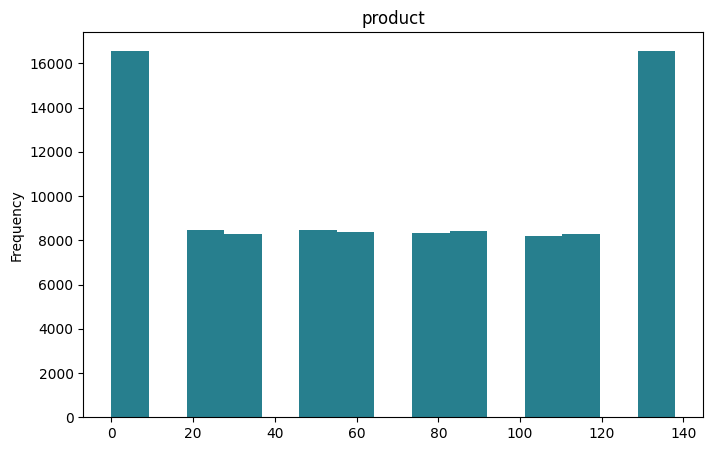

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408


In [48]:
my_hist(geo_1)

Признак "f0" распределен приблизительно от -30 до 30, симетрично вокруг среднего в 1,14 и имеет 2 пика, в районе -8, 9.\
Признак "f1" распределен нормально от -26 до 18, со среднем в 4,8 и стандартным отклонением в 5,1.\
Признак "f2" распределен равномерно от 0 до 5, наблюдается некая сегментарность в районе целых единиц от 0 до 5.\
Признак "product" распределен от 0 до 140 схоже с "f2", только с заметными пиками в районе 0 и 140, так же разбит на сегменты, приблизительно через каждые 20 единиц.

#### Третий регион

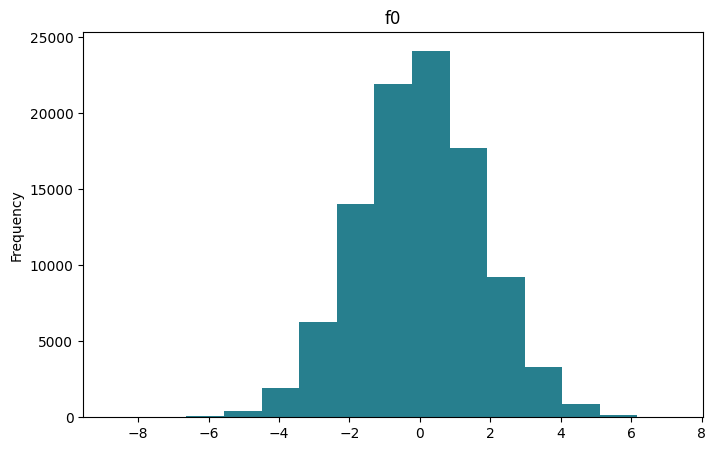

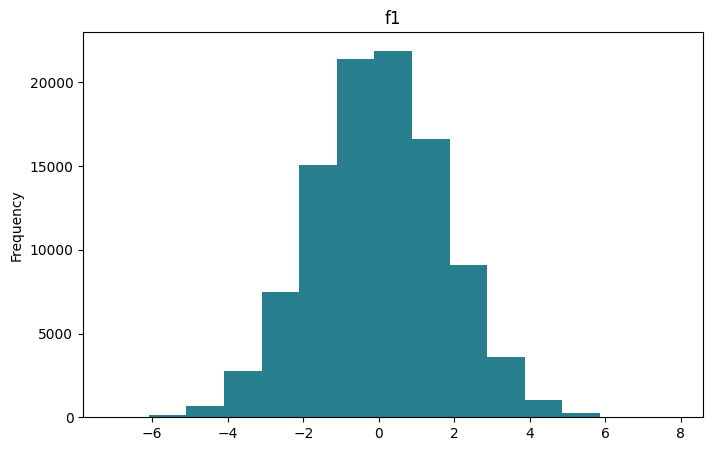

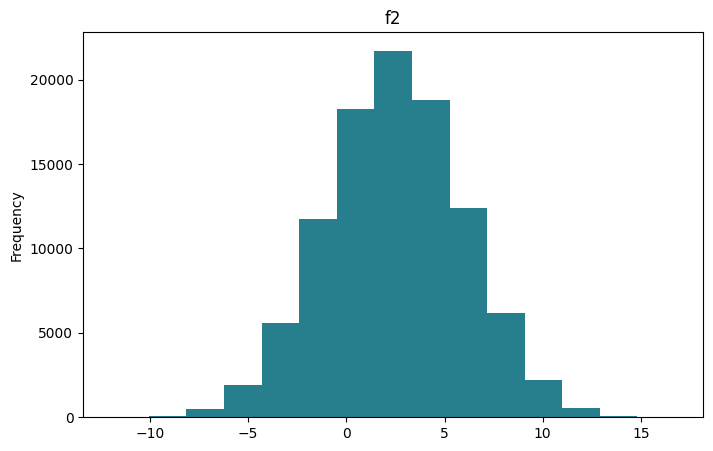

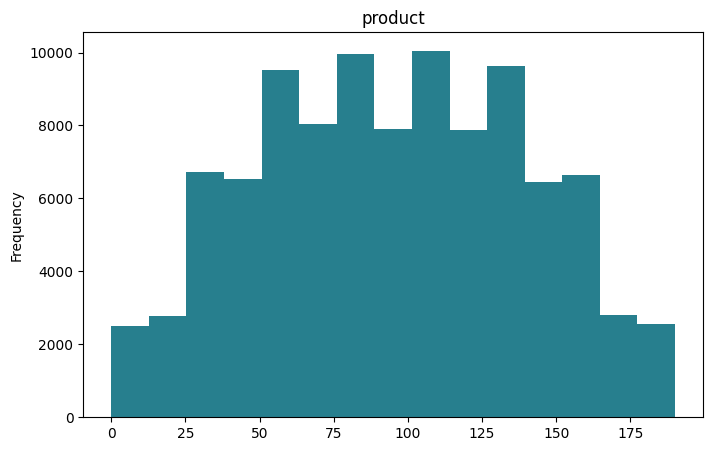

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838


In [49]:
my_hist(geo_2)

Признак "f0" распределен нормально от -8 до 7, со среднем в районе 0 и стандартным отклонением в 1,73.\
Признак "f1" распределен нормально от -7 до 7,8, со среднем в районе 0 и стандартным отклонением в 1,73.\
Признак "f2" распределен нормально от -11,9 до 16,7, со среднем в 2,49 и стандартным отклонением в 3,47.\
Признак "product" распределен симетрично от 0 до 190, вокруг среднего в 95, имеет несколько пиков с шагом в 25 единиц и стандартное отклонение 44.

### Вывод

Данные в разных регионах имеют разные распределения и стандартные отклонения, максимальные и минимальные значения у одних и тех же признаков в разных регионах отличаются кратно, заметных выбросов не наблюдается.

## Обучение и проверка модели

### Обучение модели

In [50]:
def model(df, region):
    
    X = df.drop(["id", "product"], axis=1)
    y = df["product"]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )

    num_cols = ["f0", "f1", "f2"]
    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train[num_cols])
    X_test_scaler = scaler.transform(X_test[num_cols])

    le = LinearRegression()
    le.fit(X_train_scaled, y_train)
    y_pred = le.predict(X_test_scaler)
    
    result = X_test.copy(deep=True)
    result["product"] = y_test
    result["predict"] = y_pred
    
    rmse = root_mean_squared_error(y_test, y_pred)
    
    print("----------------------Регион №{}----------------------".format(region))
    print("RMSE модели {:.2f}:".format(rmse))
    print("Средний запас предсказанного сырья {:.1f}:".format(y_pred.mean()))
    print("")

    return result

### Предсказания модели

In [51]:
geo_0_pred = model(geo_0, 1)
geo_1_pred = model(geo_1, 2)
geo_2_pred = model(geo_2, 3)

----------------------Регион №1----------------------
RMSE модели 37.76:
Средний запас предсказанного сырья 92.4:

----------------------Регион №2----------------------
RMSE модели 0.89:
Средний запас предсказанного сырья 68.6:

----------------------Регион №3----------------------
RMSE модели 40.24:
Средний запас предсказанного сырья 95.1:



### Вывод

Лучше всего справилась вторая модель, почти идеальный результат, RMSE 0,89 при среднем в 68,6 - это намного лучше чем у других двух моделей (Регион №1 - RMSE 37.76, Регион №3 - RMSE 40.24), скорее всего это связано со структурой данных у признаков датасета для второго региона, где наблюдалась выраженная сегментация признака f2 и product, также эти признаки полностью коррелируют, возможно есть утечка данных либо другие причины.

Корреляция признаков f2 и product в датасете второго региона:

In [60]:
geo_1[["f2", "product"]].corr()

,f2,product
f2,1.000000,0.999397
product,0.999397,1.000000


## Подготовка к расчёту прибыли

In [53]:
BUDGET = 10000000000 # Бюджет
INCOME_PER_UNIT = 450000 # Доход на 1 тыс. баррелей
BEST_WELLS = 200 # Кол-во разрабатываемых скважин
TOTAL_WELLS = 500 # Кол-во исследуемых скважин

Объем сырья для безубыточной разработки должен принести доход как минимум равный бюджету (10 млрд руб.). Одна единица продукта (1 тыс бар.) приносит 450 000 рублей дохода. Всего планируется разработка 200 скважин, значит необходимо бюджет поделить на 450 000 и разделить на 200 скажин, тогда мы узнаем минимальное среднее количиство единиц продукта на одну скважину для безубыточности.

In [54]:
need_prod = BUDGET / INCOME_PER_UNIT / BEST_WELLS
need_prod

111.11111111111111

Функция для расчета прибыли в регионе:

In [55]:
def profit(data):
    total_products = data.sort_values(by="predict", ascending=False).head(BEST_WELLS)["product"].sum()
    income = total_products * INCOME_PER_UNIT
    profit = income - BUDGET
    return int(profit)

In [56]:
print("Расчетная прибыль в первом регионе: {:.3f} млрд. рублей.".format(profit(geo_0_pred)/10**9))
print("Расчетная прибыль во втором регионе: {:.3f} млрд. рублей.".format(profit(geo_1_pred)/10**9))
print("Расчетная прибыль в третьем регионе: {:.3f} млрд. рублей.".format(profit(geo_2_pred)/10**9))

Расчетная прибыль в первом регионе: 3.359 млрд. рублей.
Расчетная прибыль во втором регионе: 2.415 млрд. рублей.
Расчетная прибыль в третьем регионе: 2.584 млрд. рублей.


### Вывод

Для безубыточной разработки необходимо иметь объём запасов нефти на скважину в среднем минимум 111,2 тыс баррелей. Самая высокая расчетная прибыль в первом регионе - 3,359 млрд рублей, у третьего региона - 2,599 млрд рублей, у втрого - 2,415 млрд.

## Расчёт прибыли и рисков 

In [57]:
def bootstrap(data, region):
    
    mean_values = []

    for i in range(1000):
        samples = data.sample(TOTAL_WELLS, replace=True, random_state=RANDOM_STATE).values
        samples = pd.DataFrame(samples, columns=data.columns)
        mean_profit = profit(samples)
        mean_values.append(mean_profit)

    mean_values = pd.Series(mean_values)
    lower = mean_values.quantile(0.025)
    upper = mean_values.quantile(0.975)
    risk_of_loss = (mean_values < 0).mean()
    
    print("----------------------Регион №{}----------------------".format(region))
    print("Средняя прибль: {:.2f} млн. руб.".format(mean_values.mean()/10**6))
    print("95% доверительный интервал: от {:.0f} до {:.0f}".format(lower, upper))
    print("Риск убытков {:.2%}".format(risk_of_loss))
    print("")


In [58]:
bootstrap(geo_0_pred, 1)
bootstrap(geo_1_pred, 2)
bootstrap(geo_2_pred, 3)

----------------------Регион №1----------------------
Средняя прибль: 415.66 млн. руб.
95% доверительный интервал: от -136326160 до 932343968
Риск убытков 6.20%

----------------------Регион №2----------------------
Средняя прибль: 429.54 млн. руб.
95% доверительный интервал: от 37480969 до 813804862
Риск убытков 1.50%

----------------------Регион №3----------------------
Средняя прибль: 318.15 млн. руб.
95% доверительный интервал: от -227793511 до 813881577
Риск убытков 12.30%



### Вывод

В результате работы бутстрэпа имеем только один регион с вероятностью убытков меньше 2,5% - это второй регион, у него же и самый высокий показатель прибыли и 95% доверительный интервал. Однако имеются сомнения по поводу выбора региона из-за подозрения на утечку данных целевого признака, что могло очень сильно завысить точность прогнозов модели по сравнению с остальными регионами.